In [1]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import os
import feather
from fastai.text import *

from PetData import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
path = 'C:\\work\\ML\\PetFinder\\'
bs=64

pets = get_data(isTest=False)
petsTest = get_data(isTest=True)

petsTest['AdoptionSpeed'] = 0

In [3]:
from fastai.tabular import *
from fastai.vision import *
from fastai.metrics import *
from fastai.text import *

dep_var = 'AdoptionSpeed'
cont_names, cat_names = cont_cat_split(pets, dep_var=dep_var)
procs = [FillMissing, Categorify, Normalize]
cat_names.remove('Filename')
cat_names.remove('PicturePath')
cat_names.remove('PetID')
cat_names.remove('Description')

In [4]:
cat_names, cont_names

(['Type',
  'Name',
  'Breed1',
  'Breed2',
  'Gender',
  'Color1',
  'Color2',
  'Color3',
  'MaturitySize',
  'FurLength',
  'Vaccinated',
  'Dewormed',
  'Sterilized',
  'Health',
  'State',
  'RescuerID',
  'NoImage'],
 ['Age',
  'Quantity',
  'Fee',
  'VideoAmt',
  'PhotoAmt',
  'RescuerDogCount',
  'AvgSentenceSentimentMagnitude',
  'AvgSentenceSentimentScore',
  'SentimentMagnitude',
  'SentimentScore'])

In [5]:
byPetID = pets.groupby('PetID').size().reset_index()
byPetID = byPetID.sample(frac=.1).drop([0], axis=1)
byPetID['IsValidation'] = True
pets = pd.merge(pets, byPetID, how='left', on='PetID')
pets.IsValidation = pets.IsValidation.fillna(False)

In [6]:
pets.groupby('PetID').size().reset_index().shape

(14993, 2)

In [7]:
data = (TabularList.from_df(pets, path=path, cat_names=cat_names, cont_names=cont_names, procs=procs)
                           .split_from_df(col='IsValidation')
                           .label_from_df(cols=dep_var)
                           .databunch())

In [8]:
kappa = KappaScore()
kappa.weights = "quadratic"
learn = tabular_learner(data, layers=[200,100], metrics=[accuracy, kappa])

In [9]:
pets[pets.IsValidation == True].shape

(5935, 33)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


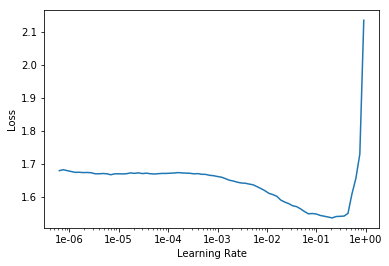

In [8]:
# learn.lr_find()
# learn.recorder.plot()

In [10]:
learn.fit_one_cycle(4, 1e-2)

epoch,train_loss,valid_loss,accuracy,kappa_score,time
0,0.473803,1.933785,0.380118,0.300651,01:00
1,0.223858,2.412245,0.399326,0.306008,00:58
2,0.086534,2.780462,0.387869,0.328848,00:58
3,0.030557,3.224016,0.399158,0.339787,00:58


In [11]:
preds,y = learn.get_preds(ds_type=DatasetType.Valid)

In [12]:
preds = torch.softmax(preds, dim=1).argmax(1).numpy()

In [14]:
predictions = pets[pets.IsValidation == True]
predictions['Prediction'] = preds
predictions = predictions.groupby('PetID').mean().round()[['Prediction', 'AdoptionSpeed']]
preds, y = predictions['Prediction'], predictions['AdoptionSpeed']

In [15]:
quadratic_weighted_kappa(preds, y)

0.3338004376268382

In [16]:
pets.shape

(58652, 33)

In [30]:
name='train'
p = pd.read_csv(name + '\\' + name + '.csv')

In [31]:
p.shape

(14993, 24)